# Example Application to estimate clumpiness factor from spectral and structural data in vineyards
From Sergio's data

## Instructions
If you have not installed pysr, run cell below.

%pip install -U pysr

Julia and Julia dependencies are installed at first import:

In [1]:
import pysr

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Now, let's import everything else as well as the PySRRegressor:


In [2]:
import sympy
import numpy as np
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Simple PySR example:


use Sergio's v4 dataset, predict LAI

In [3]:
df = pd.read_csv('RGBNIR_DSM_CHM_VIf_v4.csv')
# print(df.head())
X = df.iloc[:,1:-2]
y = df.iloc[:,-1]
print(X.head())


        Red     Green      Blue       NIR        FC       ch1        CH  \
0  0.020630  0.030237  0.003344  0.219818  0.680556  2.275999  2.451676   
1  0.020253  0.030407  0.003233  0.223823  0.652778  2.180176  2.469830   
2  0.022048  0.030032  0.003725  0.210354  0.598958  2.232824  2.363652   
3  0.022679  0.030747  0.003710  0.220522  0.500000  1.980601  2.298613   
4  0.023883  0.028469  0.003943  0.198092  0.522569  2.300652  2.226254   

         wc        WC      geom  ...      RGRI       RI4XS        SI  \
0  1.076450  0.999317  5.576198  ...  0.682277  509.138228  0.981867   
1  1.077895  0.951482  5.123413  ...  0.666062  479.839566  0.981972   
2  0.965705  0.912254  4.814528  ...  0.734158  597.604433  0.981337   
3  0.908815  0.783081  3.565081  ...  0.737611  575.514103  0.980890   
4  0.817703  0.845029  4.328101  ...  0.838918  868.336743  0.981177   

          SR      TDVI       TGI       TVI      TriVI      VARI   VrNIRBI  
0  10.655179  0.396112  1.949825  1.1525

By default, we will set up 30 populations of expressions (which evolve independently except for migrations),# use 4 threads, and use `"best"` for our model selection strategy:

In [4]:
default_pysr_params = dict(
    populations=30,
    model_selection="best", #"score" is also an option,
    random_state=0, # the 3 lines below ensure reproducible results
    deterministic=True,
    parallelism='serial',
    # select_k_features=10, # to automatically select few predictors from the entire set of predictor options, activate/deactive as you wish
    # denoise=True, # to remove scatteting on y, activate/deactivate as you wish
    verbosity =0,
    # elementwise_loss ='L2DistLoss', #The least squares loss metric
)

PySR can run for arbitrarily long, and continue to find more and more accurate expressions. You can set the total number of cycles of evolution with `niterations`, although there are also a [few more ways](https://github.com/MilesCranmer/PySR/pull/134) to stop execution.

**This first execution will take a bit longer to startup, as the library is JIT-compiled. The next execution will be much faster.**

In [5]:
# Learn equations
model = PySRRegressor(
    niterations=30,
    binary_operators=["+", "*","-","/"],
    # unary_operators=["sqrt", "exp", "log"],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    **default_pysr_params,
)

model.fit(X, y)

C:\Users\alfon\anaconda3\envs\PySR\Lib\site-packages\pysr\sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          0.7318139   
	1  >>>>  0.069483                                 NormR + 0.63610655   
	2        0.051810                  (NLI * -0.27477893) - -0.87142897   
	3        0.018770         ((GARI * SAVI) * -0.41946587) - -0.9170561   
	4        0.020937  ExR + (((SAVI * -0.3824418) * GARI) - -0.8986686)   
	5        0.033980  ((IKAW + 0.7215682) + (IPVI * (-0.80641556 * M...   
	6        0.030741  ((IKAW / 1.3500779) + ((MRBVI * -0.5157377) + ...   
	7        0.010203  ((IKAW / 1.3659428) + (ExR / 0.43098974)) + ((...   
	8        0.009617  (((MRBVI * IPVI) * -0.57016397) + ((IKAW / 1.3...   
	9        0.005405  (((IKAW / 1.3652025) + 0.7100352) + ((MRBVI * ...   
	
	       loss  complexity  
	0  0.004757           1  
	1  0.004140           3  
	2  0.003732           5  
	3  0.003595           7  
	4  0.003448           9  
	5  0.003221          11  
	6  0.003029          13  
	7  0.002968          15  
	8  0.002911          17  
	9  0.002880          19  
]

We can print the model, which will print out all the discovered expressions:

In [6]:
#model

We can also view the SymPy format of the best expression:

In [7]:
model.sympy()

NormR + 0.63610655

We can also view the SymPy of any other expression in the list, using the index of it in `model.equations_`.

In [8]:
model.sympy(2)

NLI*(-0.27477893) - 1*(-0.87142897)

## Output

`model.equations_` is a Pandas DataFrame. We can export the results in various ways:

In [9]:
model.latex()

'NormR + 0.636'

These is also `model.sympy(), model.jax(), model.pytorch()`. All of these can take an index as input, to get the result for an arbitrary equation in the list.

We can also use `model.predict` for arbitrary equations, with the default equation being the one chosen by `model_selection`:

ypredict = model.predict(X)
ypredict_simpler = model.predict(X, 2)

print("Default selection MSE:", np.power(ypredict - y, 2).mean())
print("Manual selection MSE for index 2:", np.power(ypredict_simpler - y, 2).mean())

Plotting the first 20 solutions

IndexError: single positional indexer is out-of-bounds

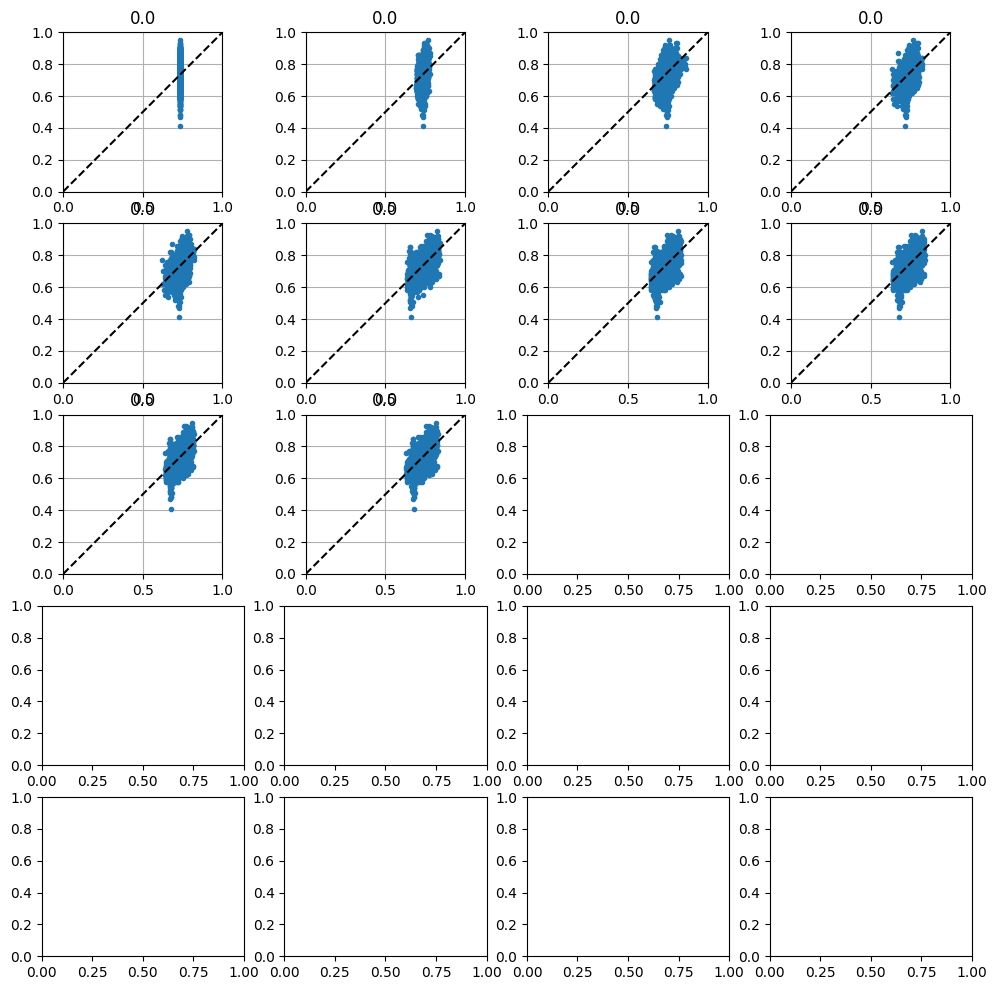

In [10]:
fig, axes = plt.subplots(5, 4, figsize=(12, 12))

it = np.linspace(0,19,20, dtype=int)  # Ensure indices are integers

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    ax.plot(ypredict_simpler, y,'.')
    ax.grid(True)
    # ax.set_xlabel("Modeled LAI")
    # ax.set_ylabel("Measured LAI")
    ax.plot( [0,1], [0,1], linestyle='--', color='k' )

    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    mse =np.power(ypredict_simpler - y, 2).mean()
    ax.set_title(round(mse,2))
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



Plotting the difference between the predicted and measured LAI

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(12, 12))

it = np.linspace(0,19,20, dtype=int)  # Ensure indices are integers

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    ax.plot(y,ypredict_simpler-y,'.')
    ax.grid(True)
    # ax.set_xlabel("Modeled LAI")
    # ax.set_ylabel("Measured LAI")
    # ax.plot( [0,5], [-5,5], linestyle='--', color='k' )

    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(-1, 1)
    mse =np.power(ypredict_simpler - y, 2).mean()
    ax.set_title(round(mse,2))
    ax.grid(True)

# Adjust layout to prevent overlap
# plt.tight_layout()
plt.show()



# Other PySR Options

The full list of PySR parameters can be found here: https://ai.damtp.cam.ac.uk/pysr/api